### Cab-Driver Agent

In [1]:
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time
import math
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

In [2]:
from Env import CabDriver

#### Defining Time Matrix

In [3]:
Time_matrix = np.load("TM.npy")

In [4]:
print(Time_matrix.max())
print(Time_matrix.min())
print(Time_matrix.mean())
print(Time_matrix.var())

11.0
0.0
3.0542857142857143
7.93705306122449


### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [5]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size

        self.discount_factor = 0.95
        self.learning_rate = 0.01
        self.epsilon = 1
        self.epsilon_max = 1
        self.epsilon_decay = -0.0005 
        self.epsilon_min = 0.00001
        
        self.batch_size = 32        
        self.memory = deque(maxlen=2000)
        self.states_tracked = []
        self.track_state = np.array(env.state_encod_arch1([0,0,0])).reshape(1, 36)
        self.model = self.build_model()

        
    def build_model(self):
        input_shape = self.state_size
        model = Sequential()
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model



    def get_action(self, state, possible_actions_index, actions):
        if np.random.rand() <= self.epsilon:
            return random.choice(possible_actions_index)
        else:
            state = np.array(env.state_encod_arch1(state)).reshape(1, 36)
            q_value = self.model.predict(state)
            q_vals_possible = [q_value[0][i] for i in possible_actions_index]
            return possible_actions_index[np.argmax(q_vals_possible)]
        


    def append_sample(self, state, action_index, reward, next_state, done):
        self.memory.append((state, action_index, reward, next_state, done))
    
    
    
    def train_model(self):
        if len(self.memory) > self.batch_size:
            mini_batch = random.sample(self.memory, self.batch_size)
            update_input = np.zeros((self.batch_size, self.state_size))
            update_output = np.zeros((self.batch_size, self.state_size))
            actions, rewards, done = [], [], []
            
            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean = mini_batch[i]
                update_input[i] = env.state_encod_arch1(state)     
                actions.append(action)
                rewards.append(reward)
                update_output[i] = env.state_encod_arch1(next_state)
                done.append(done_boolean)
                
            target = self.model.predict(update_input)

            target_qval = self.model.predict(update_output)
                                
            for i in range(self.batch_size):
                if done[i]:
                    target[i][actions[i]] = rewards[i]
                else: 
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])

            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
        
        
    def save_tracking_states(self):
       q_value = self.model.predict(self.track_state)
        
        print("States_tracked value {0}.".format(q_value[0][2]))

        self.states_tracked.append(q_value[0][2])         

        
    def save(self, name):
        self.model.save(name)

In [6]:
episode_time = 24*30 #30 days before which car has to be recharged
n_episodes = 5000
m = 5 # number of cities, ranges from 1 ..... m
t = 24 # number of hours, ranges from 0 .... t-1
d = 7  # number of days, ranges from 0 ... d-1

env = CabDriver()
action_space, state_space, state = env.reset()

state_size = m+t+d
action_size = len(action_space)

agent = DQNAgent(action_size=action_size, state_size=state_size)

rewards_per_episode, episodes = [], []

rewards_init_state = []

### DQN block

In [7]:
start_time = time.time()
score_tracked = []

for episode in range(n_episodes):

    done = False
    score = 0
    track_reward = False

    env = CabDriver()
    action_space, state_space, state = env.reset()

    initial_state = env.state_init

    total_time = 0  
    while not done:

        possible_actions_indices, actions = env.requests(state)
        action = agent.get_action(state, possible_actions_indices, actions)
        reward, next_state, step_time = env.step(state, env.action_space[action], Time_matrix)
        total_time += step_time
        
        if (total_time > episode_time):
            done = True
        else:
            agent.append_sample(state, action, reward, next_state, done)
            agent.train_model()
            score += reward
            state = next_state

    rewards_per_episode.append(score)
    episodes.append(episode)
    
    agent.epsilon = (1 - 0.00001) * np.exp(agent.epsilon_decay * episode)

    if ((episode + 1) % 10 == 0):
        print("episode {0}, reward {1}, memory_length {2}, epsilon {3} total_time {4}".format(episode,
                                                                         score,
                                                                         len(agent.memory),
                                                                         agent.epsilon, total_time))
    if ((episode + 1) % 5 == 0):
        agent.save_tracking_states()

    score_tracked.append(score)

    if(episode % 1000 == 0):
        print("Saving Model {}".format(episode))
        agent.save(name="SuperCabs_car_model.h5")

    
elapsed_time = time.time() - start_time
print(elapsed_time)


Saving Model 0
States_tracked value 304.4028015136719.
episode 9, reward 7.0, memory_length 1313, epsilon 0.9955001547284723 total_time 724.0
States_tracked value 522.7093505859375.
States_tracked value 167.4105987548828.
episode 19, reward -54.0, memory_length 2000, epsilon 0.9905350769930761 total_time 735.0
States_tracked value 249.53982543945312.
States_tracked value 270.0930480957031.
episode 29, reward 52.0, memory_length 2000, epsilon 0.9855947626861951 total_time 721.0
States_tracked value 320.3605041503906.
States_tracked value 321.0106506347656.
episode 39, reward -360.0, memory_length 2000, epsilon 0.9806790882997144 total_time 726.0
States_tracked value 279.5391845703125.
States_tracked value 404.996826171875.
episode 49, reward -226.0, memory_length 2000, epsilon 0.9757879309415182 total_time 723.0
States_tracked value 254.5122528076172.
States_tracked value 312.4140625.
episode 59, reward -13.0, memory_length 2000, epsilon 0.9709211683324178 total_time 721.0
States_tracke

States_tracked value 38185.11328125.
episode 499, reward 40.0, memory_length 2000, epsilon 0.7791824889264571 total_time 721.0
States_tracked value 27028.478515625.
States_tracked value 24538.4375.
episode 509, reward -324.0, memory_length 2000, epsilon 0.7752963000502389 total_time 725.0
States_tracked value 19035.552734375.
States_tracked value 16875.58984375.
episode 519, reward 81.0, memory_length 2000, epsilon 0.7714294936219019 total_time 723.0
States_tracked value 14399.642578125.
States_tracked value 12331.7158203125.
episode 529, reward 70.0, memory_length 2000, epsilon 0.7675819729710842 total_time 721.0
States_tracked value 12443.9541015625.
States_tracked value 10436.3642578125.
episode 539, reward -638.0, memory_length 2000, epsilon 0.763753641909569 total_time 731.0
States_tracked value 7549.69287109375.
States_tracked value 11946.005859375.
episode 549, reward -175.0, memory_length 2000, epsilon 0.7599444047288803 total_time 731.0
States_tracked value 7689.3193359375.
St

States_tracked value 20574.728515625.
episode 989, reward -330.0, memory_length 2000, epsilon 0.6098696702013323 total_time 732.0
States_tracked value 10431.9296875.
States_tracked value 3956.127685546875.
episode 999, reward 18.0, memory_length 2000, epsilon 0.6068279325314512 total_time 721.0
States_tracked value 1935.9139404296875.
Saving Model 1000
States_tracked value 1256.39453125.
episode 1009, reward 131.0, memory_length 2000, epsilon 0.6038013655914889 total_time 729.0
States_tracked value 1520.9752197265625.
States_tracked value 721.2274169921875.
episode 1019, reward 86.0, memory_length 2000, epsilon 0.6007898937171146 total_time 726.0
States_tracked value 521.9391479492188.
States_tracked value 338.407958984375.
episode 1029, reward 186.0, memory_length 2000, epsilon 0.5977934416213744 total_time 721.0
States_tracked value 427.4251708984375.
States_tracked value 633.1947021484375.
episode 1039, reward -457.0, memory_length 2000, epsilon 0.5948119343928097 total_time 725.0
S

States_tracked value 131.6743927001953.
episode 1469, reward 209.0, memory_length 2000, epsilon 0.47974047419983834 total_time 723.0
States_tracked value 127.60548400878906.
States_tracked value 112.10054779052734.
episode 1479, reward 122.0, memory_length 2000, epsilon 0.4773477586026542 total_time 724.0
States_tracked value 110.39350891113281.
States_tracked value 148.04910278320312.
episode 1489, reward -25.0, memory_length 2000, epsilon 0.474966976724297 total_time 722.0
States_tracked value 106.52484130859375.
States_tracked value 107.71459197998047.
episode 1499, reward 145.0, memory_length 2000, epsilon 0.47259806904509577 total_time 724.0
States_tracked value 206.07418823242188.
States_tracked value 136.2652587890625.
episode 1509, reward 64.0, memory_length 2000, epsilon 0.4702409763422352 total_time 730.0
States_tracked value 125.76786041259766.
States_tracked value 213.84007263183594.
episode 1519, reward 173.0, memory_length 2000, epsilon 0.4678956396882749 total_time 722.0

States_tracked value 149.68197631835938.
episode 1949, reward -22.0, memory_length 2000, epsilon 0.3773772230868729 total_time 728.0
States_tracked value 186.01499938964844.
States_tracked value 208.25318908691406.
episode 1959, reward 405.0, memory_length 2000, epsilon 0.37549504633451936 total_time 726.0
States_tracked value 167.6663818359375.
States_tracked value 185.5288543701172.
episode 1969, reward -170.0, memory_length 2000, epsilon 0.37362225697788115 total_time 725.0
States_tracked value 176.13140869140625.
States_tracked value 167.75967407226562.
episode 1979, reward 510.0, memory_length 2000, epsilon 0.37175880819712703 total_time 727.0
States_tracked value 183.7158203125.
States_tracked value 215.32794189453125.
episode 1989, reward 225.0, memory_length 2000, epsilon 0.3699046534059402 total_time 722.0
States_tracked value 161.13058471679688.
States_tracked value 161.84657287597656.
episode 1999, reward 150.0, memory_length 2000, epsilon 0.3680597462503545 total_time 732.0

States_tracked value 274.4881591796875.
episode 2429, reward 810.0, memory_length 2000, epsilon 0.2968554378120623 total_time 723.0
States_tracked value 281.42572021484375.
States_tracked value 311.5320129394531.
episode 2439, reward 531.0, memory_length 2000, epsilon 0.2953748651392093 total_time 728.0
States_tracked value 342.0050354003906.
States_tracked value 330.64093017578125.
episode 2449, reward 738.0, memory_length 2000, epsilon 0.2939016768533689 total_time 721.0
States_tracked value 355.7039794921875.
States_tracked value 403.39794921875.
episode 2459, reward 397.0, memory_length 2000, epsilon 0.2924358361247571 total_time 725.0
States_tracked value 377.50848388671875.
States_tracked value 380.266845703125.
episode 2469, reward 623.0, memory_length 2000, epsilon 0.2909773063072796 total_time 722.0
States_tracked value 444.39031982421875.
States_tracked value 441.3909912109375.
episode 2479, reward 172.0, memory_length 2000, epsilon 0.28952605093761474 total_time 721.0
States

States_tracked value 178.41867065429688.
episode 2909, reward 271.0, memory_length 2000, epsilon 0.23351475809207786 total_time 725.0
States_tracked value 198.92478942871094.
States_tracked value 244.32745361328125.
episode 2919, reward 225.0, memory_length 2000, epsilon 0.2323500983772779 total_time 728.0
States_tracked value 224.37876892089844.
States_tracked value 202.93142700195312.
episode 2929, reward 270.0, memory_length 2000, epsilon 0.2311912474270389 total_time 729.0
States_tracked value 190.71298217773438.
States_tracked value 204.03857421875.
episode 2939, reward 68.0, memory_length 2000, epsilon 0.23003817627002682 total_time 725.0
States_tracked value 184.00155639648438.
States_tracked value 159.0513153076172.
episode 2949, reward -71.0, memory_length 2000, epsilon 0.22889085607940265 total_time 722.0
States_tracked value 197.08270263671875.
States_tracked value 165.98773193359375.
episode 2959, reward 519.0, memory_length 2000, epsilon 0.22774925817210187 total_time 728.

episode 3379, reward 276.0, memory_length 2000, epsilon 0.18460996070570268 total_time 722.0
States_tracked value 155.43121337890625.
States_tracked value 176.57362365722656.
episode 3389, reward 496.0, memory_length 2000, epsilon 0.18368921468544486 total_time 723.0
States_tracked value 203.1069793701172.
States_tracked value 243.92544555664062.
episode 3399, reward 478.0, memory_length 2000, epsilon 0.18277306090512138 total_time 728.0
States_tracked value 235.4464874267578.
States_tracked value 222.0184783935547.
episode 3409, reward 348.0, memory_length 2000, epsilon 0.18186147646083992 total_time 727.0
States_tracked value 251.34555053710938.
States_tracked value 193.60784912109375.
episode 3419, reward 632.0, memory_length 2000, epsilon 0.18095443856294197 total_time 721.0
States_tracked value 251.58529663085938.
States_tracked value 231.34912109375.
episode 3429, reward 540.0, memory_length 2000, epsilon 0.1800519245354328 total_time 730.0
States_tracked value 222.50021362304688

States_tracked value 251.750244140625.
episode 3859, reward 298.0, memory_length 2000, epsilon 0.14521933852150737 total_time 721.0
States_tracked value 240.2424774169922.
States_tracked value 252.70326232910156.
episode 3869, reward 42.0, memory_length 2000, epsilon 0.14449505404900642 total_time 723.0
States_tracked value 253.56787109375.
States_tracked value 251.41375732421875.
episode 3879, reward 69.0, memory_length 2000, epsilon 0.1437743819603825 total_time 729.0
States_tracked value 225.0614013671875.
States_tracked value 189.0601806640625.
episode 3889, reward 504.0, memory_length 2000, epsilon 0.14305730423879587 total_time 735.0
States_tracked value 187.599853515625.
States_tracked value 279.5137634277344.
episode 3899, reward 447.0, memory_length 2000, epsilon 0.1423438029572661 total_time 727.0
States_tracked value 167.64056396484375.
States_tracked value 175.88894653320312.
episode 3909, reward 263.0, memory_length 2000, epsilon 0.141633860278224 total_time 725.0
States_t

States_tracked value 225.887939453125.
episode 4339, reward 405.0, memory_length 2000, epsilon 0.11423357764667307 total_time 728.0
States_tracked value 226.78175354003906.
States_tracked value 214.48757934570312.
episode 4349, reward 153.0, memory_length 2000, epsilon 0.11366383530126595 total_time 731.0
States_tracked value 253.6133575439453.
States_tracked value 247.206787109375.
episode 4359, reward 261.0, memory_length 2000, epsilon 0.11309693455766137 total_time 731.0
States_tracked value 179.922607421875.
States_tracked value 225.25729370117188.
episode 4369, reward 486.0, memory_length 2000, epsilon 0.1125328612433112 total_time 736.0
States_tracked value 192.17156982421875.
States_tracked value 215.1902618408203.
episode 4379, reward 524.0, memory_length 2000, epsilon 0.11197160125635315 total_time 723.0
States_tracked value 231.60025024414062.
States_tracked value 236.372314453125.
episode 4389, reward 744.0, memory_length 2000, epsilon 0.11141314056525843 total_time 722.0
St

States_tracked value 247.6566162109375.
episode 4819, reward 474.0, memory_length 2000, epsilon 0.0898593148461825 total_time 725.0
States_tracked value 195.17138671875.
States_tracked value 275.81121826171875.
episode 4829, reward 402.0, memory_length 2000, epsilon 0.08941113964365587 total_time 724.0
States_tracked value 221.01852416992188.
States_tracked value 219.99276733398438.
episode 4839, reward 34.0, memory_length 2000, epsilon 0.08896519972427712 total_time 726.0
States_tracked value 241.91201782226562.
States_tracked value 231.29000854492188.
episode 4849, reward 522.0, memory_length 2000, epsilon 0.08852148393952511 total_time 725.0
States_tracked value 222.85643005371094.
States_tracked value 249.84339904785156.
episode 4859, reward -58.0, memory_length 2000, epsilon 0.08807998119648211 total_time 721.0
States_tracked value 222.05776977539062.
States_tracked value 220.45742797851562.
episode 4869, reward 388.0, memory_length 2000, epsilon 0.0876406804575565 total_time 725.

# Save the tracked state

In [8]:
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [9]:
save_obj(agent.states_tracked,"Cabs_model_weights")

### Tracking Convergence

In [10]:
agent.states_tracked

[304.4028,
 522.70935,
 167.4106,
 249.53983,
 270.09305,
 320.3605,
 321.01065,
 279.53918,
 404.99683,
 254.51225,
 312.41406,
 547.2708,
 399.41498,
 478.51465,
 543.8777,
 657.75494,
 521.2496,
 499.082,
 522.8732,
 535.3721,
 448.97638,
 380.93863,
 933.1831,
 403.09735,
 537.1973,
 641.51025,
 641.7321,
 482.98355,
 588.21497,
 432.93765,
 437.15497,
 565.02136,
 586.85034,
 541.86096,
 499.06454,
 525.42377,
 478.9427,
 427.89325,
 509.49026,
 718.3084,
 552.5717,
 488.13614,
 433.46286,
 2199.1343,
 497.64523,
 644.8488,
 806.98175,
 1994.9595,
 6585.887,
 872.991,
 564.27875,
 584.8876,
 1143.6244,
 7799.486,
 4814.2534,
 9898.746,
 11515.243,
 23073.504,
 7787.4736,
 8274.629,
 21517.322,
 183758.27,
 129220.68,
 151320.44,
 102134.555,
 68199.96,
 49786.71,
 42763.723,
 35575.992,
 35118.105,
 33640.375,
 32318.41,
 36281.363,
 48565.605,
 39554.496,
 35642.008,
 21026.07,
 14364.465,
 9114.041,
 10301.813,
 13684.333,
 17572.19,
 30790.03,
 24037.287,
 32824.324,
 46922.953

In [11]:
state_tracked_sample = [agent.states_tracked[i] for i in range(len(agent.states_tracked)) if agent.states_tracked[i] < 1000]

### Plot the Q-Value convergence for state action pairs

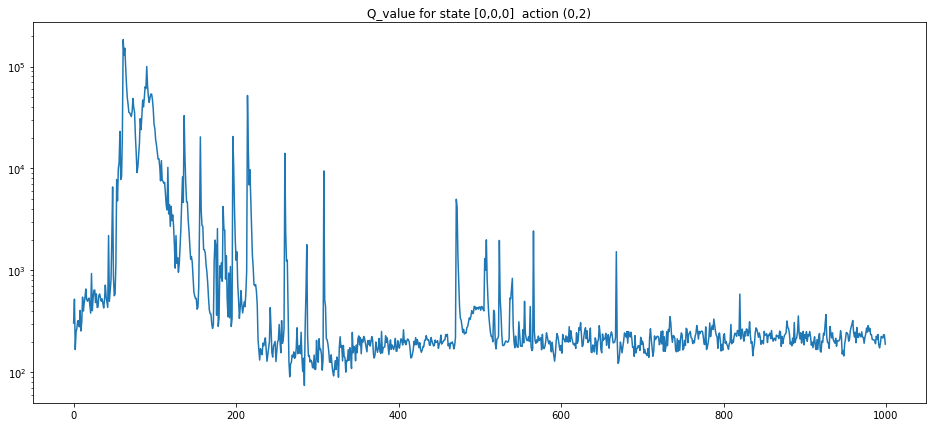

In [12]:
plt.figure(0, figsize=(16,7))
plt.title('Q_value for state [0,0,0]  action (0,2)')
xaxis = np.asarray(range(0, len(agent.states_tracked)))
plt.semilogy(xaxis,np.asarray(agent.states_tracked))
plt.show()

### Track rewards per episode.

In [13]:
score_tracked_sample = [score_tracked[i] for i in range(len(score_tracked)) if (i % 4 == 0)]

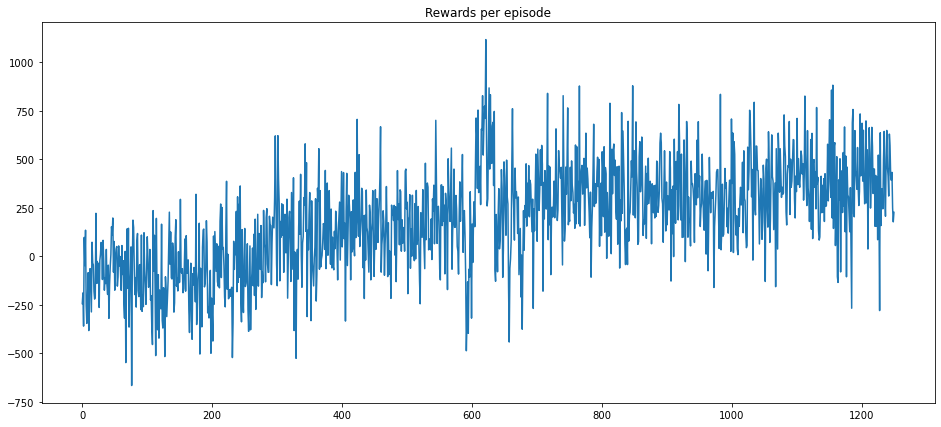

In [14]:
plt.figure(0, figsize=(16,7))
plt.title('Rewards per episode')
xaxis = np.asarray(range(0, len(score_tracked_sample)))
plt.plot(xaxis,np.asarray(score_tracked_sample))
plt.show()

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [15]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

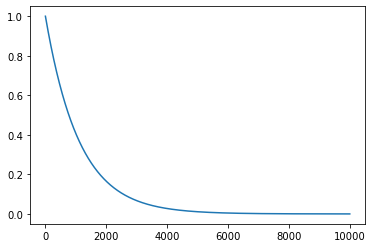

In [16]:
plt.plot(time, epsilon)
plt.show()